# Dermatology Disease Classification

## Objectives

The UCI Dermatology disease dataset contains clinical and histological factors

- [Request Data From UCI Repository & Format to Dataframe](Request-Data-From-UCI-Repository-&-Format)
- [Clean and Prepare Data](Clean-and-Prepare-Data)
- [Get Predictors and Response Class](Get-Predictors-and-Response-Class)
- [Perform Linear Discriminant Analysis and Cross Validate](Perform-Linear-Discriminant-Analysis-and-Cross-Validate)
- [LDA Results](LDA-Results)
- [Project Clinical Data onto Largest LDA Components](Project-Clinical-Data-onto-Largest-LDA-Components)

In [123]:
import glob
import requests
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from io import StringIO
from operator import itemgetter
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cross_validation import cross_val_score
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
plt.style.use('ggplot')

## Request Data From UCI Repository & Format

In [2]:
if glob.glob('data/data.txt') and glob.glob('data/description.txt'):
    print('Data read from disk')
    # read in data to pandas df
    df = pd.read_csv('data/data.txt', na_values='?')
    # read in the description string
    with open('data/description.txt', 'r') as outfile:
            desc_str = outfile.read()
    
else:
    print('Data Requested From UCI')
    data_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/dermatology/' + \
               'dermatology.data'
    desc_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/dermatology/' + \
                'dermatology.names'

    data_response = requests.get(data_url)
    desc_response = requests.get(desc_url)
                       
    if data_response.status_code and desc_response.status_code == 200:  
        
        # write the description file to data directory
        with open('data/description.txt', 'w') as outfile:
            outfile.write(desc_response.text)
           
        desc_str = desc_response.text
        # regex extract pattern ['int': attribute]
        predictor_tuples = re.findall('(\d+): ([\w -]+)', desc_str)
        # convert attribute string -> int and subs '_' for white spaces or hyphens
        predictors_tuples = [(int(tup[0]), re.sub('[\s-]', '_', tup[1].strip())) 
                      for tup in predictor_tuples]
        # sort the predictors by the attribute number
        predictors = sorted(predictors_tuples, key=itemgetter(0))
        # last feature is the response 'Disease' Class
        attributes = [p[1] for p in predictors]+['Disease']
        #use string IO to read in data to dataframe
        data = StringIO(data_response.text)
        df = pd.read_csv(data, header=None, names=attributes)
        
        # write the dataframe to a csv 'data/data.txt'
        df.to_csv('data/data.txt', index_label=False)

Data read from disk


In [3]:
df.head()

,erythema,scaling,definite_borders,itching,koebner_phenomenon,polygonal_papules,follicular_papules,oral_mucosal_involvement,knee_and_elbow_involvement,scalp_involvement,...,disappearance_of_the_granular_layer,vacuolisation_and_damage_of_basal_layer,spongiosis,saw_tooth_appearance_of_retes,follicular_horn_plug,perifollicular_parakeratosis,inflammatory_monoluclear_inflitrate,band_like_infiltrate,Age,Disease
0,2,2,0,3,0,0,0,0,1,0,...,0,0,3,0,0,0,1,0,55.0,2
1,3,3,3,2,1,0,0,0,1,1,...,0,0,0,0,0,0,1,0,8.0,1
2,2,1,2,3,1,3,0,3,0,0,...,0,2,3,2,0,0,2,3,26.0,3
3,2,2,2,0,0,0,0,0,3,2,...,3,0,0,0,0,0,3,0,40.0,1
4,2,3,2,2,2,2,0,2,0,0,...,2,3,2,3,0,0,2,3,45.0,3


## Clean and Prepare Data

In [118]:
df = df.dropna() # corresponds to 8 entries where age was not recorded
df = df.astype(float)

In [119]:
#print(desc_str)

## Get Predictors and Response Class

We will split the predictors into two groupings; the clinical predictors will be the 12 predictors that are measured in a clinic without biopsy, the histological predictors will be the predictors that can only be obtained by lesioning the skin. 

In [7]:
# Get the clinical and histological predictors dropping the disease response class var.
clinical_predictors = df.columns.tolist()[0:11] + ['Age']
histo_predictors = df.columns.tolist()[11:33]

# get arrays of the disease class number and the predictor values
y = df['Disease'].values
X_clinical = df[clinical_predictors]
X_histo = df[histo_predictors]

## Perform Linear Discriminant Analysis and Cross-Validate

Lets build a Linear Discriminant model to attempt to predict the disease class from the clinical and histological predictors. We will use a 10-fold cross-validation since the dataset is small (358 instances)

In [129]:
# shrinkage 'auto' because we don't have that many data points compared with predictors
lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto', n_components=3)
lda.fit(X_clinical,y)

print('(Disease Class, Priors) =\n', list(zip(range(1,8), lda.priors_)))
print('\n')
print('Explained Variance Ratios = \n', lda.explained_variance_ratio_)

(Disease Class, Priors) =
 [(1, 0.31005586592178769), (2, 0.16759776536312848), (3, 0.19832402234636873), (4, 0.13407821229050279), (5, 0.13407821229050279), (6, 0.055865921787709494)]


Explained Variance Ratios = 
 [  5.55676824e-01   3.27958506e-01   1.61770913e-01   7.26150954e-02
   5.84656267e-02   1.82068651e-02   2.32441510e-03   4.85358819e-04
  -9.89306489e-03  -1.96273762e-02  -8.17997891e-02  -8.61833740e-02]


In [27]:
lda_accuracy = np.mean(cross_val_score(lda, X_clinical, y, cv=10))
print('LDA Accuracy Using Clinical Predictors = ', lda_accuracy)

Linear Discriminant Accuracy Using Clinical Markers =  0.824750601995


In [28]:
lda_accuracy = np.mean(cross_val_score(lda, X_histo, y, cv=10))
print('LDA Accuracy Using Histological Predictors = ', lda_accuracy)

Linear Discriminant Accuracy Using Histological Markers =  0.938691090471


## LDA Results

Using the clinical markers only, the LDA model correctly predicts 82% of the disease categories. Including the histological markers the correct predictions rise to 94%. We will use the 94% accuracy as a benchmark for non-linear models shortly.

## Project Clinical Data onto Largest LDA Components

In LDA we are maximizing the between class variance relative to the within class variance. The eignevectors are the directions in the predictor space that accomplish this maximization. The corresponding eigenvalues give the amount of variance each component accounts for. In the explained variance ratio calculation above sklearn calculated $\frac{\lambda_i}{\sum{\lambda_i}}$ for each eigenvalue $\lambda_i$. There are three relatively large eigenvalues. We can therefore try to project the data onto the three associated eigenvectors to visualize the disease class separations.

In [131]:
# Transform the clinical data onto three largest eigenvectors
X_r = lda.fit_transform(X_clinical, y)

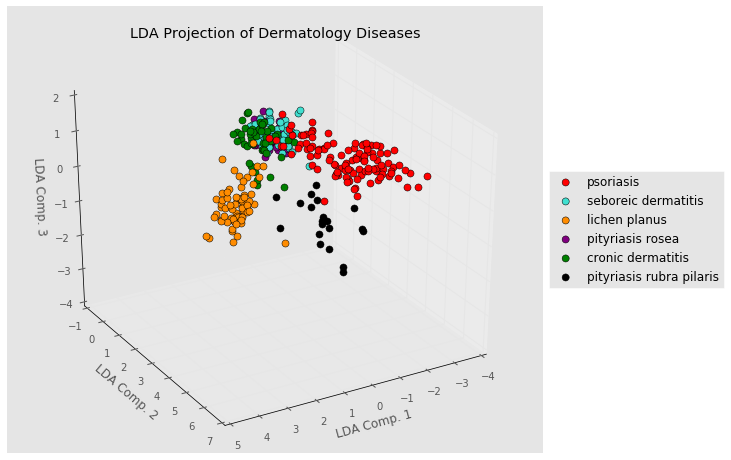

In [134]:
# Make a list of the disease names for the plot legend
disease_names = ['psoriasis', 'seboreic dermatitis', 'lichen planus', 'pityriasis rosea',
                'cronic dermatitis', 'pityriasis rubra pilaris']
# create a color for each disease class
colors = ['red', 'turquoise', 'darkorange', 'purple', 'green', 'black']
# Create a 3d plot to visualize the classes in the LDA reduced space
fig = plt.figure(figsize=(12,8))
ax3D = fig.add_subplot(111, projection='3d')
# scatter each of the diseases in the reduced LDA space
for color, disease_num, disease_name in zip(colors, list(range(1,7)), disease_names):
    ax3D.scatter(X_r[y == disease_num, 0], X_r[y == disease_num, 1],
                 X_r[y == disease_num, 2], c=color, s=50, alpha=1, 
                 edgecolor='k', label=disease_name, depthshade=False);
    
ax3D.view_init(elev=30,azim=60)
ax3D.set_xlabel('LDA Comp. 1')
ax3D.set_ylabel('LDA Comp. 2')
ax3D.set_zlabel('LDA Comp. 3')

# Shrink current axis by 20% to create room for an outside ax legend
box = ax3D.get_position()
ax3D.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), scatterpoints=1)    
#plt.legend(loc='best', shadow=False, scatterpoints=1);
plt.title('LDA Projection of Dermatology Diseases');

The LDA dimensionality reduction shows that several of the disease classes can be easily separated by eye but the dermatitis diseases are still tightly clustered togehter. Our next approach will be to try a non-linear machine learning model -- the Random Forest Classifier.